<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Data Science Basics in Python

### Bootstrap for Uncertainty Models 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### Bootstrap in Python 

Here's a simple workflow, demonstration of bootstrap for modeling workflows. This should help you get started with this important data analytics method to evaluate and integrate uncertainty for any statistic or model.  

#### Bootstrap

Uncertainty in statistics
* one source of uncertainty is the paucity of data.
* do 200 or even less samples provide a precise (and accurate estimate) of the mean? standard deviation? skew? P13?

Would it be useful to know the uncertainty in these statistics due to limited sampling?
* what is the impact of uncertainty in the mean porosity e.g. 20%+/-2%?
* empirically calculate standard errors, confidence intervals and to conduct hypothesis testing

**Bootstrap** is a method to assess the uncertainty in a statistic by repeated random sampling with replacement to create multiple simulated data sets.

#### The Bootstrap Workflow (Efron, 1982)

Statistical resampling procedure to calculate uncertainty in a calculated statistic from the data itself.
* Does this work?  Prove it to yourself, for uncertainty in the mean solution is standard error: 

\begin{equation}
\sigma^2_\overline{x} = \frac{\sigma^2_s}{n}
\end{equation}

Extremely powerful - could calculate uncertainty in any statistic!  e.g. P13, skew etc.
* Would not be possible access general uncertainty in any statistic without bootstrap.
* Advanced forms account for spatial information and sampling strategy (game theory and Journel’s spatial bootstrap (1993).

Steps: 

&nbsp;&nbsp;**1.** assemble a representative sample set or build a cumulative distribution function (CDF) using analog data and/or declustering weights

&nbsp;&nbsp;**2.** For $\ell = 1, \ldots, L$ realizations, do the following:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For $i = \alpha, \ldots, n$ samples, do the following:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Draw a random sample with replacement from the sample set or Monte Carlo simulate from the CDF. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate a realization of the statistic from the $n$ samples, e.g. $m^\ell$, $\sigma^2_{\ell}$.

&nbsp;&nbsp;**3.** Compile and summarize the $L$ realizations of the statistic of interest.

This is a very powerful method.  Let's try it out. But first...

#### Bootstrap Assumptions and Limitations

* **representativity** - samples are sufficient, representative
* **stationarity** - metric of interest is invariant under translation (identically distributed)
* **no spatial context** - independent samples (no between sample correlation), does not account for boundary of area of interest and local information sources
* **uncertainty source** - only accounts for uncertainty due to too few samples (no uncertainty due nonstationarity, multiple populations or measurement errors)


#### Project Goal

Learn the basics for working with bootstrap for Uncertainty Modeling in Python to build practical spatial data analytics, geostatistics and machine learning workflows.

* Focus on customization and not a survey of available plot times

#### Caveats

I included methods that I have found useful for building my science and engineering workflows for subsurface modeling. 

* Accessibility for most scientists and engineers is my goal. 
* There are more advanced, more compact, more efficient methods to accomplish the same tasks. 
* I appreciate feedback and I will use it to improve these walk-throughs.

#### Load and Configure the Required Libraries

The following code loads the required libraries and sets a plotting default.

In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import matplotlib
from scipy import stats                   # summary statistics
import math                               # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # random sampling
from scipy.stats import gaussian_kde      # for PDF calculation
from scipy.stats import t                 # Student's t distribution for analytical solution
import seaborn as sns                     # for advanced plotting

#### Convenience Functions for Plotting

These are convenience functions to visualize the data and bootstrap results.
* **custom_histogram** - data histogram with summary statistics 
* **custom_histogram_with_uncert** - data histogram with boostrap uncertainty model 
* **display_bootstrap** - bootstrap realizations' histogram with analytical or empirical PDF

I include these for concise, readable workflows.

In [2]:
def custom_histogram(zdata,zmin,zmax,xlabel,title):
    offset = (zmax-zmin)/30.0
    freq = plt.hist(zdata,color = 'red',alpha = 0.3,edgecolor='black',bins = np.linspace(zmin,zmax,int(len(zdata)/3)))[0]
    ht = np.max(freq)
    plt.axvline(x=np.average(zdata),linestyle="--",c='black')
    plt.text(np.average(zdata)+offset,ht*0.95, r'Average = ' + str(round(np.average(zdata),1)), fontsize=12)
    plt.text(np.average(zdata)+offset,ht*0.90, r'St.Dev. = ' + str(round(np.std(zdata),1)), fontsize=12)
    plt.text(np.average(zdata)+offset,ht*0.85, r'P10 = ' + str(round(np.percentile(zdata,10),1)), fontsize=12)
    plt.text(np.average(zdata)+offset,ht*0.80, r'P90 = ' + str(round(np.percentile(zdata,90),1)), fontsize=12)
    plt.xlabel(xlabel); plt.ylabel('Frequency'); plt.title(title)
     
def custom_histogram_with_uncert(zreal,zmin,zmax,zdata,xlabel,title):
    offset = (zmax-zmin)/30.0
    freq = plt.hist(zdata,color = 'red',alpha = 0.2,edgecolor='grey',bins = np.linspace(zmin,zmax,int(len(zdata)/3)))[0]
    ht = np.max(freq)
    plt.axvline(x=np.average(zdata),c='black')
    plt.axvline(x=np.percentile(zreal,90),linestyle="--",c='black')
    plt.axvline(x=np.percentile(zreal,10),linestyle="--",c='black')
    plt.text(np.percentile(zreal,90)+offset,ht*0.90, r'Average = ' + str(round(np.average(zreal),1)), fontsize=12)
    plt.text(np.percentile(zreal,90)+offset,ht*0.85, r'Average P90 = ' + str(round(np.percentile(zreal,90),1)), fontsize=12)
    plt.text(np.percentile(zreal,90)+offset,ht*0.80, r'Average P10 = ' + str(round(np.percentile(zreal,10),1)), fontsize=12)
    plt.xlabel(xlabel); plt.ylabel('Frequency'); plt.title(title)

def display_bootstrap(zreal,zmin,zmax,zdata,title,abin,analytical,stat):
    offset = (zmax-zmin)/30.0
    freq = plt.hist(zreal,color = 'red',alpha = 0.2,edgecolor = 'black',bins=np.linspace(zmin,zmax,100),label = 'bootstrap',density = True)[0] # plot the distribution, could also calculate any summary statistics
    ht = np.max(freq)
    if analytical is None:
        sns.kdeplot(x=zreal,color = 'grey',alpha = 0.1,levels = 1,bw_adjust = 1,label='bootstrap PDF') 
        plt.xlabel('Boostrap Realizations and Kernel Density Estimate') 
    else:    
        plt.plot(abin,analytical,color = 'black',label = 'analytical',alpha=0.4)
        plt.fill_between(abin, 0, analytical, where = abin <= np.percentile(zreal,10), facecolor='red', interpolate=True, alpha = 0.5)
        plt.fill_between(abin, 0, analytical, where = abin >= np.percentile(zreal,90), facecolor='red', interpolate=True, alpha = 0.5)
        plt.xlabel('Boostrap Realizations and Analytical Sampling Distributions') 
    plt.axvline(x=stat(zdata),linestyle="--",c='black')
    plt.text(stat(zdata)+offset,ht*0.95, r'Average = ' + str(round(np.average(zreal),1)), fontsize=12)
    plt.text(stat(zdata)+offset,ht*0.90, r'St.Dev. = ' + str(round(np.std(zreal),1)), fontsize=12)
    plt.text(stat(zdata)+offset,ht*0.85, r'P90 = ' + str(round(np.percentile(zreal,90),1)), fontsize=12)
    plt.text(stat(zdata)+offset,ht*0.8, r'P10 = ' + str(round(np.percentile(zreal,10),1)), fontsize=12)
    plt.ylabel('Frequency'); plt.title(title)
    plt.legend(loc = 'upper left')

#### Set the Random Number Seed

Since we will be random sampling, Monte Carlo simulation for sampling with replacement, we set the random number seed for worklfow repeatability

* note, if you rerun any bootstrap code blocks the results will change unless the seed is set in each code block

In [3]:
seed = 13                                 # random number generator seed 
random.seed(a=seed)                       # initialize the random number generator  

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
os.chdir("c:/PGE383")                     # set the working directory

#### Load the Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [5]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
#df = pd.read_csv('sample_data_biased.csv') # load our data table from the working directory

#### Feature Engineering

We do just a couple basic things:

* let's drop some samples so that we increase the variations in bootstrap samples for our demonstration below.

* let's convert porosity from fraction to percentage (100x)

In [6]:
fraction = 0.1                             # set proportion of data to retain and observe the uncertainty 
df['Porosity'] = df['Porosity']*100        # convert fraction to percentage
df = df.sample(frac = fraction,random_state=seed) # extract a random subset  
print('Using ' + str(len(df)) + ' number of samples')

Using 29 number of samples


#### Visualize the DataFrame

Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW).

In [7]:
df.head()                                 # display first 4 samples in the table as a preview

,X,Y,Facies,Porosity,Perm
107,390,779,1,19.328012,495.525997
209,530,789,1,15.487071,51.991055
30,800,800,1,12.783107,3.294085
207,450,689,1,15.476265,82.943101
221,490,959,1,19.656596,403.008633


#### Calculate Summary Statistics

The data includes **X** and **Y** coordinates (meters), **Facies** 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), **Porosity** (fraction), and **Permeability** as Perm (mDarcy). 

In [8]:
df.describe().transpose()                 # summary statistics         

,count,mean,std,min,25%,50%,75%,max
X,29.0,463.103448,246.520116,20.000000,300.000000,430.000000,550.000000,900.000000
Y,29.0,563.137931,325.808524,89.000000,199.000000,619.000000,839.000000,959.000000
Facies,29.0,0.896552,0.309934,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,29.0,13.943832,3.584357,7.996248,11.684271,12.740454,15.487071,21.821727
Perm,29.0,155.973329,376.973510,0.111985,3.967875,11.806496,98.144295,1954.288198


#### Basic Data Visualization Parameters

Let's set the areal extents (X and Y), feature extents and color map.

In [9]:
xmin = 0.0; xmax = 1000.0                 # limits for X coordinate
ymin = 0.0; ymax = 1000.0                 # limits for Y coordinate
pormin = 5.0; pormax = 25.0;              # limits for Porosity feature
permmin = 0.01; permmax = 10000           # limits for Permeability feature
cmap = plt.cm.inferno                     # color map

#### Basic Data Visualization

Let's try out location maps, histograms and scatter plots. See my other live code walk-throughs for more information.

<ipython-input-10-9feb46d03f89>:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(df['X'],df['Y'],s = 20,c = df['Perm'],cmap = cmap,linewidths = 0.3,edgecolor ='black',alpha =0.8,vmin=permmin,vmax=permmax,norm=matplotlib.colors.LogNorm())


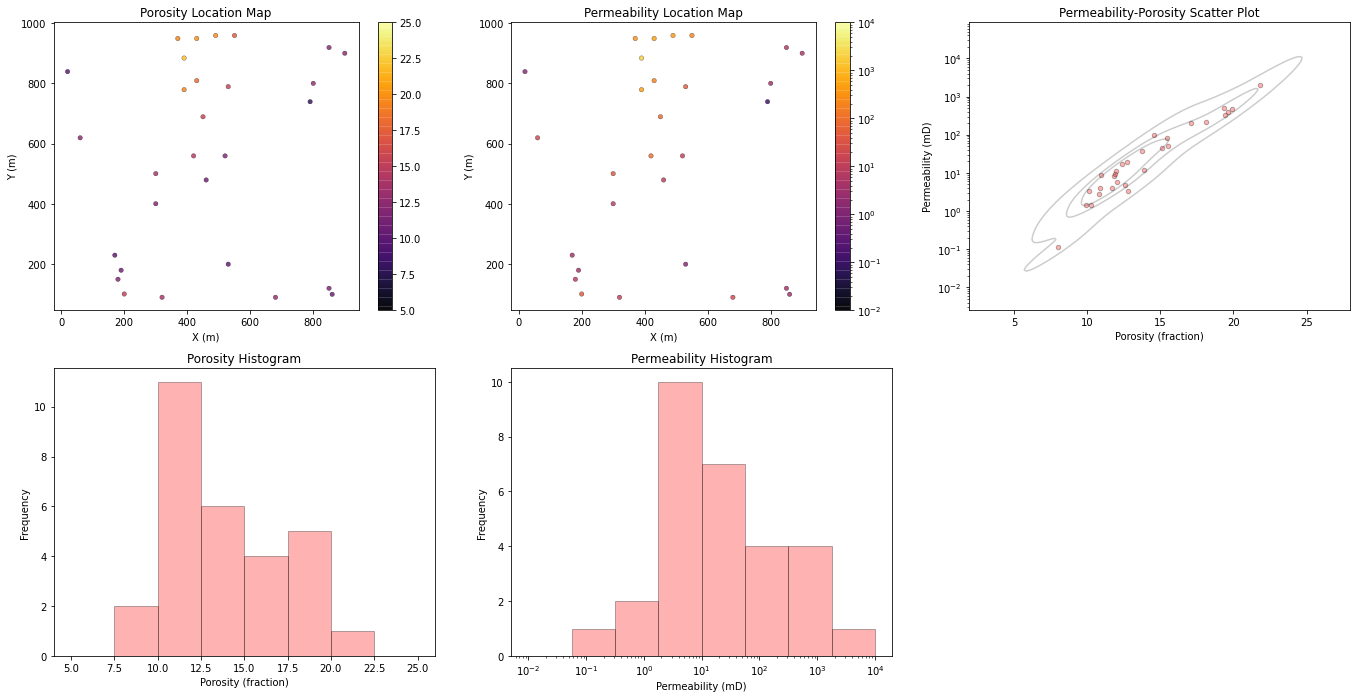

In [10]:
plt.subplot(231)
plt.scatter(df['X'],df['Y'],s=20,c=df['Porosity'],cmap=cmap,linewidths=0.3,edgecolor='black',alpha=0.8,vmin=pormin,vmax=pormax)
plt.colorbar(); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Location Map')

plt.subplot(234)
plt.hist(df['Porosity'],color='red',alpha=0.3,edgecolor='black',bins=np.linspace(pormin,pormax,int(len(df)/3)))
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram')

plt.subplot(232)
plt.scatter(df['X'],df['Y'],s = 20,c = df['Perm'],cmap = cmap,linewidths = 0.3,edgecolor ='black',alpha =0.8,vmin=permmin,vmax=permmax,norm=matplotlib.colors.LogNorm())
plt.colorbar(); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Permeability Location Map')

plt.subplot(235)
plt.hist(df['Perm'],color='red',alpha=0.3,edgecolor='black',bins=np.logspace(np.log10(permmin),np.log10(permmax),int(len(df)/3)))
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Permeability Histogram'); plt.xscale('log')

plt.subplot(233)
plt.scatter(df['Porosity'],df['Perm'],s=20,color='red',alpha=0.3,edgecolor='black')
plt.ylabel('Permeability (mD)'); plt.xlabel('Porosity (fraction)'); plt.title('Permeability-Porosity Scatter Plot')
plt.yscale('log')
sns.kdeplot(x=df['Porosity'],y=df['Perm'],color = 'black',alpha=0.2,levels=4)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.2, wspace=0.2, hspace=0.2)
plt.show()

### Bootstrap Method in Python                       

If you are new to bootstrap and Python, here's a simple pseudocode workflow for bootstrap.

* specify the number of bootstrap realizations, $L$
* declare a list to store the bootstrap realizations of the statistic of interest
* loop over $L$ bootstrap realizations
    * $n$ MCS, random samples with replacement for a new realization of the data
    * calculate the realization of the statistic from the realization of the data
* summarize the resulting uncertainty model, histogram, summary statistics etc.

#### Bootstrap of the Sample Mean, Arithmetic Average

Let's make a simple bootstrap function where:
* **zdata** is a 1D ndarray of the original data
* **nreal** is the number of bootstrap realizations to calculate
* **stat** is a function that calculates the statistic

In [11]:
def bootstrap(zdata,nreal,stat):
    zreal = []                            # declare an empty list to store the bootstrap realizations
    for l in range(0,nreal):              # loop over the L bootstrap realizations
        samples = random.choices(zdata, k=len(zdata)) # n Monte Carlo simulations, sample with replacement
        zreal.append(stat(samples))       # calculate the realization of the statistic and append to list
    return zreal                          # return the list of realizations of the statistic

#### Additional Declarations for Read-able Code

Let's add a couple more declarations for concise, read-able code

In [12]:
por = df['Porosity'].values               # copy DataFrame series, Porosity feature, to 1D ndarray
lpor = np.linspace(pormin,pormax,100)     # calculate bins for plotting

#### Demonstration of Bootstrap for Uncertainty in the Mean

Let's bootstrap to calculate the uncertainty in the mean. We will compare the bootstrap results with the analytical expression:

\begin{equation}
\mu \sim \overline{x} \pm t_{\frac{\alpha}{2},n-1}\sqrt{\frac{s^2}{n}}
\end{equation}

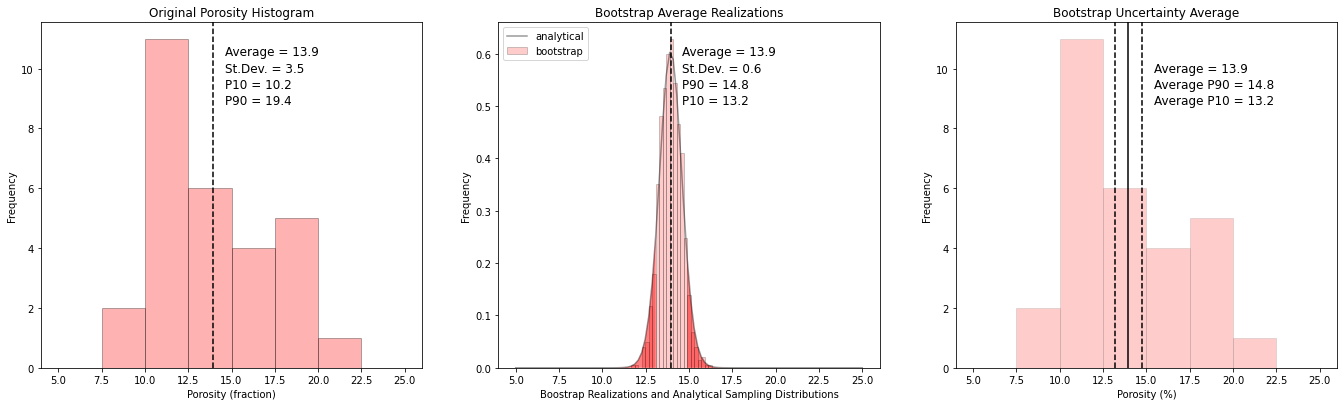

In [13]:
L = 1000; random.seed(a=seed)             # set the number and seed for the bootstrap realizations   
por_avg_real = bootstrap(por,L,np.average) # bootstrap of the arithmetic average 

plt.subplot(131)                          # plot the original data
custom_histogram(por,pormin,pormax,'Porosity (fraction)','Original Porosity Histogram')
plt.subplot(132)                          # plot the bootstrap results
mod = t.pdf(lpor,len(df)-1,loc=np.average(por),scale=math.sqrt(np.var(por)/len(df))) # analytical PDF
display_bootstrap(por_avg_real,pormin,pormax,por,'Bootstrap Average Realizations',lpor,mod,np.average)
plt.subplot(133)                          # plot the original data and bootstrap results 
custom_histogram_with_uncert(por_avg_real,pormin,pormax,por,'Porosity (%)','Bootstrap Uncertainty Average')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Optional: Write out the Bootstrap Samples for Uncertainty in the Mean

Set the file name and feature name and write your bootstrap realizations as a .csv file.

* file will be written in the current working directory

In [35]:
filename = 'avg_por_boot.csv'             # specify file name and feature name for writing out
featurename = 'avg_por_boot'

df_boot = pd.DataFrame(data=por_avg_real,columns=[featurename]) # DataFrame with the bootstrap realizations
df_boot.to_csv(filename,index=False)      
df_boot.head()

,avg_por_boot
0,13.505598
1,13.896181
2,13.771810
3,13.872079
4,14.120102


#### Demonstration of Bootstrap for Uncertainty in the Standard Deviation

Let's perform bootstrap of a measure of dispersion, the standard deviation, $\sigma_x$.

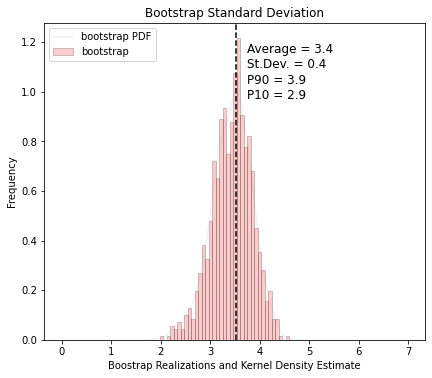

In [36]:
L = 1000; random.seed(a=seed)             # set the number and seed for the bootstrap realizations   
por_stdev_real = bootstrap(por,L,np.std)  # bootstrap of the standard deviation

plt.subplot(131)                          # plot the bootstrap results                       
display_bootstrap(por_stdev_real,0,7,por,'Bootstrap Standard Deviation',lpor,None,np.std)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Bootstrap of the Coefficient of Variation

Here's a statistic that is derived from multiple statistics for each bootstrap realization of the data.

* $CV_x^{\ell} = \frac{s_x^{\ell}}{\overline{x}_x^{\ell}}$ 

* this reinforces that we bootstrap dataset realizations and then calculate the statistic on this dataset realization

For the coefficient of variation we will:
    
* calculate a bootstrap realization of the dataset with $n$ samples with replacement
* calculate the mean and standard deviation from this bootstrapped realization of the dataset
* calculate a boostrap realization of the coefficient of variation as the standard deviation realizaiton divided by the mean realization

Repeat this $L$ time on $L$ realizations of the data and then evaluate the resulting distribution.

#### Demonstration of Bootstrap for Uncertainty in the Coefficient of Variation

Now bootstrap uncertainty of coefficient of variation, $CV_x^{\ell} = \frac{s_x^{\ell}}{\overline{x}_x^{\ell}}$ 

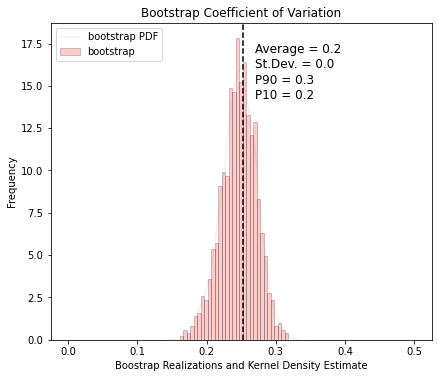

In [37]:
cv = lambda x: np.std(x) / np.mean(x)     # define lambda function to calculate coefficient of variation
L = 1000; random.seed(a=seed)             # set the number and seed for the bootstrap realizations   
por_cv_real = bootstrap(por,L,cv)         # bootstrap of the interquartile range 

plt.subplot(131)                          # plot the bootstrap results 
display_bootstrap(por_cv_real,0,0.5,por,'Bootstrap Coefficient of Variation',lpor,None,cv)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Demonstration of Bootstrap for Uncertainty in the Interquartile Range

Here's another statistic that is derived from a combination of statistics, interquartile range, $IQR_x^{\ell} = F_x^{\ell}(0.75) - F_x^{\ell}(0.25)$

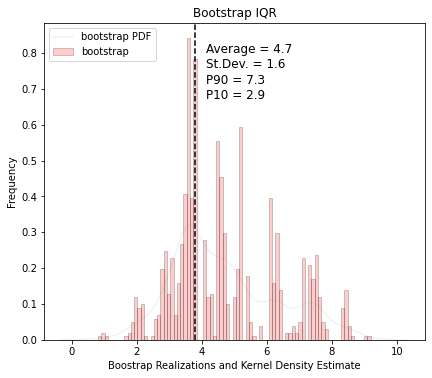

In [38]:
L = 1000; random.seed(a=seed)             # set the number and seed for the bootstrap realizations   
por_iqr_real = bootstrap(por,L,stats.iqr) # bootstrap of the interquartile range 

plt.subplot(131)                          # plot the bootstrap results 
display_bootstrap(por_iqr_real,0,10,por,'Bootstrap IQR',lpor,None,stats.iqr)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Demonstration of Bootstrap for Uncertainty in the Percentile

Now let's select any percentile and bootstrap it.

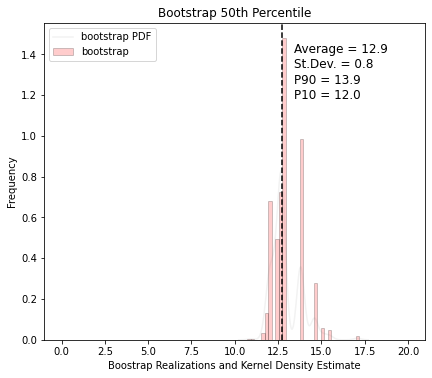

In [40]:
percentile = 50                                  # percentile to bootstrap (in percentage)
def my_percentile(data):                  # define a function to calculate this specific percentile
    return np.percentile(data,percentile)

L = 1000; random.seed(a=seed)             # set the number and seed for the bootstrap realizations   
por_per_real = bootstrap(por,L,my_percentile) # bootstrap of a specified percentile 

plt.subplot(131)                          # plot the bootstrap results 
display_bootstrap(por_per_real,0,20,por,'Bootstrap ' + str(per) + 'th Percentile',lpor,None,my_percentile)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Demonstration of Bootstrap for Uncertainty in the Proportion

Let's demonstrate another case for which we have the analytical solution to check our bootstrap results.

\begin{equation}
P \sim \hat{p} \pm t_{\frac{\alpha}{2},n-1}\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
\end{equation}

We will a big, ad hoc function to assist with this presentation. More could be done to factor, generalize the code.

In [41]:
def proportion_bootstrap_viz(zdata,nreal,nbin): 
    sand_prop_real = []                       # declare an empty list to store the bootstrap realizations of the statistic 
    shale_prop_real = []
    
    for k in range(0,L):                      # loop over the L bootstrap realizations
        samples = random.choices(zdata, k=len(zdata)) # n Monte Carlo simulations
        sand_prop_real.append(samples.count(1)/len(zdata)) # calculate the statistic of interest from the new bootstrap dataset
        shale_prop_real.append(samples.count(0)/len(zdata)) # calculate the statistic of interest from the new bootstrap dataset       
    sand_prop = np.sum(zdata == 1)/len(zdata); shale_prop = np.sum(zdata == 0)/len(df)
    
    fig = plt.subplot(121) 
    barlist = plt.bar(x=['shale','sand'],height = [1-sand_prop,sand_prop],color = 'red',alpha = 0.3,edgecolor='black')
    barlist[0].set_color('blue')
    plt.text(-.3, shale_prop+0.02, r'Prop. Shale = ' + str(round(shale_prop,2)), fontsize=12)
    plt.text(0.7, sand_prop+0.02, r'Prop. Sand = ' + str(round(sand_prop,2)), fontsize=12)
    plt.xlabel('Rock Type / Facies'); plt.ylabel('Frequency'); plt.title('Facies Histogram')
    plt.ylim([0,1]); plt.yticks(np.arange(0, 1.1, 0.1))
    
    plt.subplot(122)     
    plt.hist(sand_prop_real,color = 'red',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.0,1.0,nbin),label = 'sand',density = True) # plot the distribution, could also calculate any summary statistics
    analytical = t.pdf(np.linspace(0.0,1.0,200), len(df)-1,loc=sand_prop,scale=math.sqrt(sand_prop*(1.0-sand_prop)/len(df)))
    plt.plot(np.linspace(0.0,1.0,200),analytical,color = 'black',label = 'analytical',alpha=0.4)
    plt.axvline(x=sand_prop,linestyle="--",c='black')
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical, where = np.linspace(0.0,1.0,200) <= np.percentile(sand_prop_real,10), facecolor='red', interpolate=True, alpha = 0.5)
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical, where = np.linspace(0.0,1.0,200) >= np.percentile(sand_prop_real,90), facecolor='red', interpolate=True, alpha = 0.5)
    plt.text(np.average(sand_prop_real)-0.3, 7.0, r'E{Prop.} = ' + str(round(sand_prop,2)), fontsize=12)
    plt.text(np.average(sand_prop_real)-0.3, 6.6, r'P90 = ' + str(round(np.percentile(sand_prop_real,90),2)), fontsize=12)
    plt.text(np.average(sand_prop_real)-0.3, 6.2, r'P10 = ' + str(round(np.percentile(sand_prop_real,10),2)), fontsize=12)
    
    plt.hist(shale_prop_real,color = 'blue',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.0,1.0,nbin),label = 'shale',density = True) # plot the distribution, could also calculate any summary statistics
    analytical_shale = t.pdf(np.linspace(0.0,1.0,200), len(df)-1,loc=shale_prop,scale=math.sqrt(shale_prop*(1.0-shale_prop)/len(df)))
    plt.plot(np.linspace(0.0,1.0,200),analytical_shale,color = 'black',alpha=0.4)
    plt.axvline(x=shale_prop,linestyle="--",c='black')
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical_shale, where = np.linspace(0.0,1.0,200) <= np.percentile(shale_prop_real,10), facecolor='blue', interpolate=True, alpha = 0.5)
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical_shale, where = np.linspace(0.0,1.0,200) >= np.percentile(shale_prop_real,90), facecolor='blue', interpolate=True, alpha = 0.5)
    plt.text(np.average(shale_prop_real)+0.07, 7.0, r'E{Prop.} = ' + str(round(shale_prop,2)), fontsize=12)
    plt.text(np.average(shale_prop_real)+0.07, 6.6, r'P90 = ' + str(round(np.percentile(shale_prop_real,90),2)), fontsize=12)
    plt.text(np.average(shale_prop_real)+0.07, 6.2, r'P10 = ' + str(round(np.percentile(shale_prop_real,10),2)), fontsize=12)
    
    plt.xlabel('Boostrap Realizations and Analytical Sampling Distributions'); plt.ylabel('Frequency'); plt.title('Distribution of Bootstrap Proportions')
    plt.legend(loc = 'upper left')
    
    return sand_prop_real, shale_prop_real

#### Demonstration of Bootstrap for Uncertainty in the Proportion

Here's the original facies, categorical feature normalized histrogram and bootstrap uncertainty in proportions.

* given enough bootstrap realizations, we have a good match with the analytical prediction

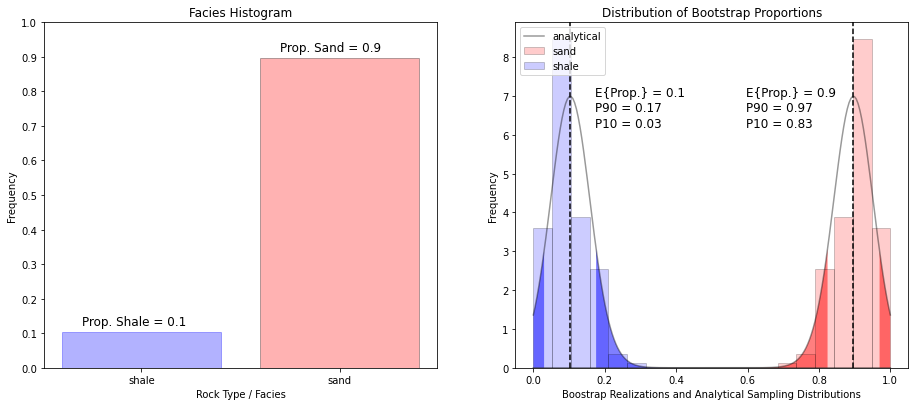

In [42]:
sand_prop_real,shale_prop_real = proportion_bootstrap_viz(zdata=df['Facies'].values,nreal=10000,nbin=20)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Optional: Write out the Bootstrap Samples for an Uncertainty in the Proportions Model

Set the file name and feature name and write your bootstrap realizations as a .csv file.

* file will be written in the current working directory

In [43]:
filename2 = 'prop_facies_boot.csv'        # specify file and feature name for writing out
featurename2 = ['sand_prop_boot','shale_prop_boot']

df_prop_boot = pd.DataFrame(data=np.column_stack((sand_prop_real,shale_prop_real)),columns=[featurename2]) # make a DataFrame with the bootstrap realizations
df_prop_boot.to_csv(filename2,index=False)

#### Comments

This was a basic demonstration of bootstrap.Remember:

* you can use bootstrap to calculate uncertainty for any statistic!

* you are calculating realizations of the statistic, representing uncertainty due to small sample size

* note the assumptions of bootstrap, including stationarity and representativity

* remember, get a dataset realization by bootstrap and then calculate the realization of the statistic from the dataset realization

* if your statistic has multiple inputs (e.g. P25 and P75), calculate each from the same bootstrap realization of the dataset.

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
